In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from astropy.time import Time
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from astropy import constants as const
import seaborn as sns
from style import output_folder, big_fontsize, base_width, base_height, dpi
from astropy.io import fits

In [2]:
# plt.rcParams["font.family"] = "sans-serif"
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{romanbar}')

In [3]:
redshift = 1. + 0.55708

conversion_factor = 4 * np.pi * cosmo.luminosity_distance(z=(redshift-1)).to(u.cm) **2. / (redshift)

In [4]:
data = fits.open("data/bzb.fits")

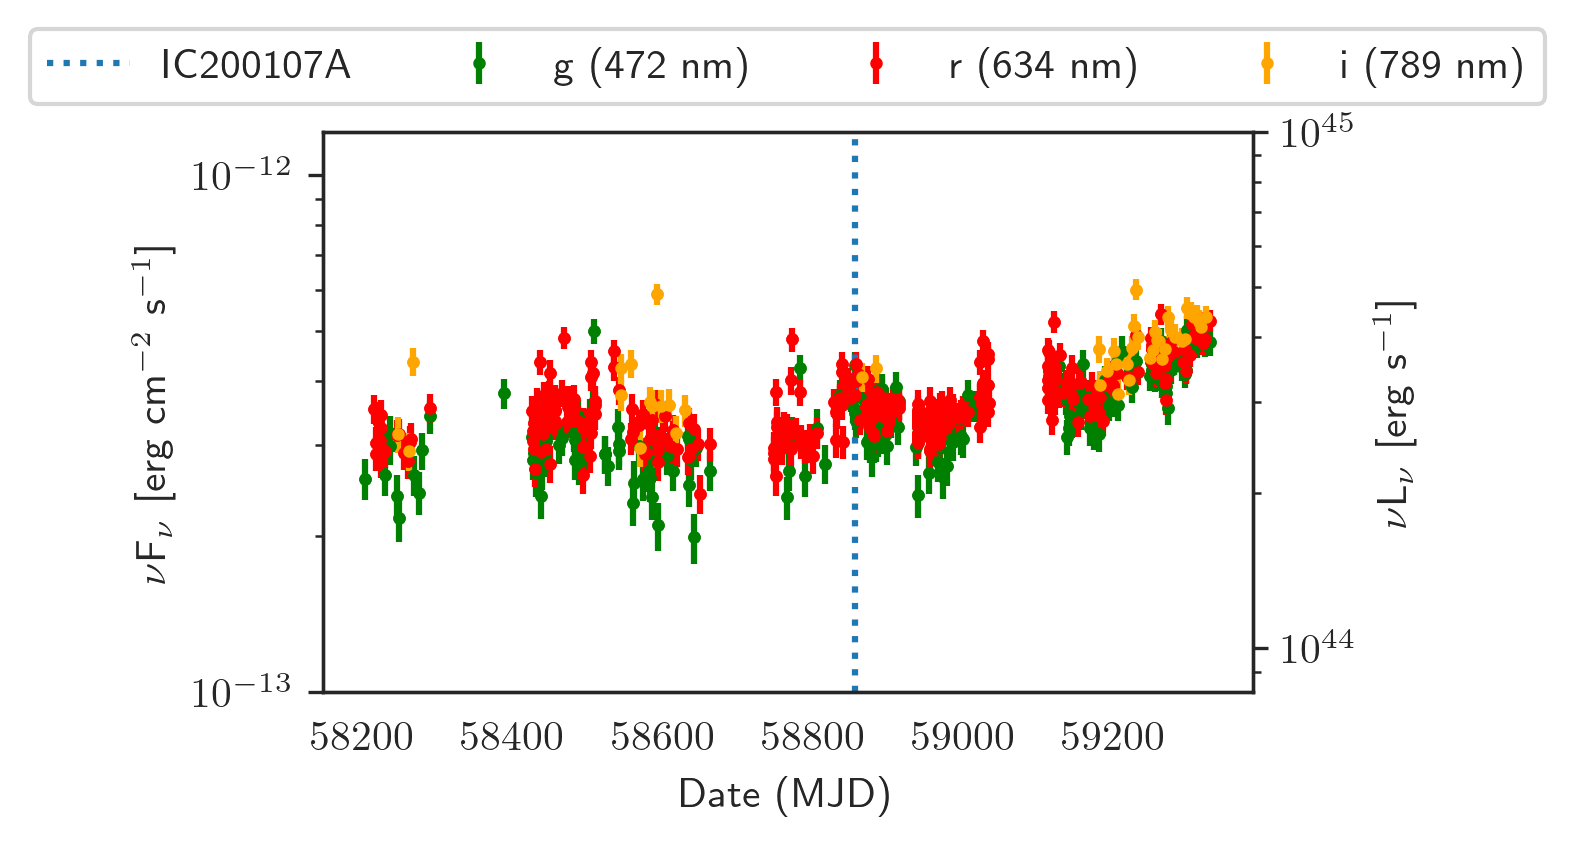

In [7]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)
ax1b = ax.twinx()

cmap = {
    "zg": "g",
    "zr": "r",
    "zi": "orange"
}

cmap2 = {
    1: "g",
    2: "r",
    3: "orange"
}

wl = {
    "zg": 472.27,
    "zr": 633.96,
    "zi": 788.61,
}

markersize=2.

log = True


for fc in ["zg", "zr", "zi"]:
    mask = data[1].data["filtercode"] == fc
    
    mags = data[1].data["mag"][mask] * u.ABmag
    
    flux_j = mags.to(u.Jansky)
    
    f = (const.c/(wl[fc] * u.nm)).to("Hz")
    
    flux = (flux_j * f).to("erg cm-2 s-1")
    
    magerrs = (data[1].data["magerr"][mask] + data[1].data["mag"][mask]) * u.ABmag
    jerrs = magerrs.to(u.Jansky)
    ferrs = (jerrs * f).to("erg cm-2 s-1").value - flux.value
    
    ax.errorbar(
        data[1].data["mjd"][mask], 
        flux.to("erg cm-2 s-1").value,
        yerr=ferrs,
        marker="o",
        linestyle=" ",
        markersize=markersize,
        c=cmap[fc],
        label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
    )
    
    l = flux * conversion_factor
    
    ax1b.errorbar(
        data[1].data["mjd"][mask], 
        l.to("erg s-1"),
        marker="o",
        linestyle=" ",
        markersize=markersize,
        c=cmap[fc],
        label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
    )
    
ax.set_ylabel(r"$\nu$F$_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=big_fontsize)
ax1b.set_ylabel(r"$\nu$L$_{\nu}$ [erg s$^{-1}$]", fontsize=big_fontsize)
ax.set_xlabel("Date (MJD)", fontsize=big_fontsize)


if log:
    ax.set_yscale("log")
    ax1b.set_yscale("log")
    
    y_min = 10**-13
    y_max = 10.**45./conversion_factor.value
    ax.set_ylim(y_min, y_max)
    ax1b.set_ylim(y_min * conversion_factor.value, y_max * conversion_factor.value)
    
else:
    ax.set_ylim(bottom=0.0)
    ax1b.set_ylim(bottom=0.0)
    
ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)

t_neutrino = Time("2020-01-07T09:42:18.36", format='isot', scale='utc')

ax.axvline(t_neutrino.mjd, linestyle=":", label="IC200107A")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
          ncol=4, fancybox=True, fontsize=big_fontsize)

filename = "bzb_lightcurve_flux.pdf"

output_path = os.path.join(output_folder, f"{filename}")

plt.savefig(f"plots/{filename}", bbox_inches='tight', pad_inches=0)
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)